
=== RAW DATA ===
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.0000

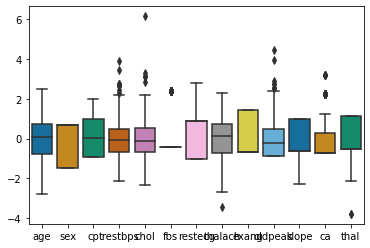


=== DATA SHAPES AFTER ALL SPLITS ===
X_train: (212, 13)
Y_train: (212,)
X_test: (91, 13)
Y_test: (91,)
Sequential(
  (0): Linear(in_features=13, out_features=1000, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1000, out_features=1, bias=True)
  (5): Sigmoid()
)

=== Training Begins ===
Epoch 0 Loss = 0.7687128186225891
Epoch 1 Loss = 1.2286237478256226
Epoch 2 Loss = 0.682074785232544
Epoch 3 Loss = 0.8459170460700989
Epoch 4 Loss = 0.45994335412979126
Epoch 5 Loss = 0.5057753324508667
Epoch 6 Loss = 0.5043424367904663
Epoch 7 Loss = 0.4268719255924225
Epoch 8 Loss = 0.33764582872390747
Epoch 9 Loss = 0.29622578620910645
Epoch 10 Loss = 0.32104194164276123
Epoch 11 Loss = 0.2628243565559387
Epoch 12 Loss = 0.22738809883594513
Epoch 13 Loss = 0.25040632486343384
Epoch 14 Loss = 0.24573403596878052
Epoch 15 Loss = 0.2118578851222992
Epoch 16 Loss = 0.19181770086288452
Epoch 17 Loss = 0.19683419167995453
Epo

In [1]:
# Heart Disease Prediction with PyTorch DNN
# June 29, 2020
# Sung Kyu Lim
# Georgia Institute of Technology
# limsk@ece.gatech.edu


### 1. IMPORT PACKAGES
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


### 2. CONSTANTS AND HYPER-PARAMETERS
INPUT_DIM = 13
MY_EPOCH = 200


### 3. LOAD AND MANIPULATE DATASET
# read DB file
df = pd.read_csv('./heart.csv', header=0)
print('\n=== RAW DATA ===')
print(df.head(5))
print(df.describe())

# split input vs. output
df_input = df.loc[:, ~(df.columns == 'target')]
df_output = df['target']

# we will use these later
names = df_input.columns.tolist()

print('\n== RAW DATA AFTER INPUT/OUTPUT SPLITTING ==')
print(df_input.head(5))
print(df_output.head(5))

# more input processing
# scaling with z-score: z = (x - u) / s
# so that mean becomes 0, and standard deviation 1
scaler = StandardScaler()
df_input = scaler.fit_transform(df_input)

# fit_transform returns numpy array
# so we convert back to dataframe
df_input = pd.DataFrame(df_input, columns=names)
print('\n=== SCALED INPUT DATA ===')
print(df_input.head(5))
print(df_input.describe())

# display box plot of scaled DB
sns.boxplot(data=df_input, palette="colorblind")
plt.show()

# split the DB into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(df_input,
    df_output, test_size=0.3, random_state=42)

# print the final dataset info
print('\n=== DATA SHAPES AFTER ALL SPLITS ===')
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_test:', X_test.shape)
print('Y_test:', Y_test.shape)


### 4. MODEL CONSTRUCTION
model = nn.Sequential(
    nn.Linear(INPUT_DIM, 1000),
    nn.Tanh(),
    nn.Linear(1000, 1000),
    nn.Tanh(),
    nn.Linear(1000, 1),
    nn.Sigmoid()
)
print(model)


### 5. MODEL TRAINING
# optimizer and loss function selection
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

# convert dataframe to PyTorch tensor
# we need to match data type, too
X_train = torch.tensor(X_train.values).float()
Y_train = torch.tensor(Y_train.values).float()

# run epochs
began = time()
print('\n=== Training Begins ===')
for epoch in range(0, MY_EPOCH):
    output = model(X_train)

    # squeeze the tensor: (212, 1) to (212)
    output = torch.squeeze(output)
    loss = criterion(output, Y_train)
    print('Epoch', epoch, 'Loss =', loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print('\n=== Training Time (in seconds) ={:.1f}'.format(time() - began))


### 6. PREDICTION AND EVALUATION
# convert dataframe to PyTorch tensor
X_test = torch.tensor(X_test.values).float()

print('\n### Test Begins')
with torch.no_grad():
    pred = model(X_test)

# use sci-kit for evaluation
# sci-kit needs numpy array, not PyTorch tensor
pred = pred.detach().numpy()
pred = (pred > 0.5)

# calculate accuracy
print("Accuracy:", f1_score(Y_test, pred))
